# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [2]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [3]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [4]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, out_dim)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [5]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_Reg4().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [6]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg_loss = total / len(loader.dataset)
            print(f'Epoch {ep}/{epochs} | avg loss = {avg_loss:.6f}')

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

train_part1(model, train_loader_1)


Epoch 1/1000 | avg loss = 0.766126
Epoch 500/1000 | avg loss = 0.102473
Epoch 1000/1000 | avg loss = 0.102664


In [7]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8860    0.7850    0.8325      2377
           C     0.9919    0.9178    0.9534      2263
           B     0.9452    0.9653    0.9552      3057
           A     0.9778    0.9796    0.9787      3144

   micro avg     0.9524    0.9200    0.9360     10841
   macro avg     0.9502    0.9120    0.9299     10841
weighted avg     0.9514    0.9200    0.9347     10841
 samples avg     0.6595    0.6497    0.6489     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2885  240]
 [ 511 1866]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3222   17]
 [ 186 2077]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2274  171]
 [ 106 2951]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2288   70]
 [  64 3080]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8874    0.7733    0.8264      1019
           C     0.9856    

c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-package

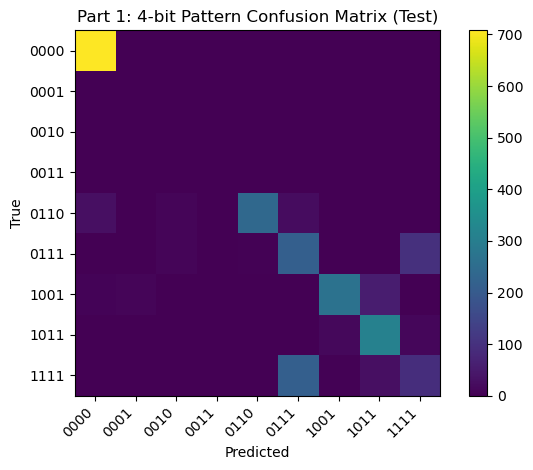

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 28   0  11   0 238  24   0   0   0]
 [  0   0  11   0   4 215   0   0  99]
 [  6  10   0   0   0   0 266  57   0]
 [  0   0   0   1   0   0  14 312  13]
 [  0   0   0   0   0 214   4  29  93]]


In [8]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [9]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [10]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, out_dim)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x  # logits (N, 4)


In [11]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiLabel4().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [12]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg_loss = total / len(loader.dataset)
            print(f'Epoch {ep}/{epochs} | avg loss = {avg_loss:.6f}')

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

train_part2(model, train_loader_2)


Epoch 1/1000 | avg loss = 0.708954
Epoch 500/1000 | avg loss = 0.218483
Epoch 1000/1000 | avg loss = 0.200356


In [13]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8169    0.8687    0.8420      2377
           C     1.0000    0.9143    0.9552      2263
           B     0.9975    0.9290    0.9621      3057
           A     0.9933    0.9873    0.9903      3144

   micro avg     0.9535    0.9296    0.9414     10841
   macro avg     0.9519    0.9248    0.9374     10841
weighted avg     0.9572    0.9296    0.9425     10841
 samples avg     0.6637    0.6550    0.6547     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2662  463]
 [ 312 2065]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 194 2069]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 217 2840]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2337   21]
 [  40 3104]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8250    0.8606    0.8425      1019
           C     1.0000    

c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linwh\anaconda3\Lib\site-package

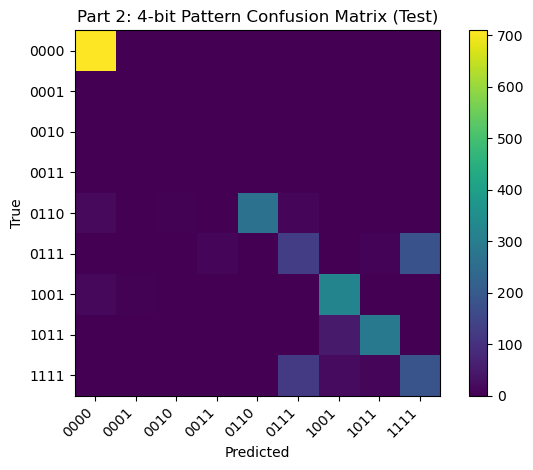

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 18   0   4   0 269  10   0   0   0]
 [  0   0   0  13   2 128   0   6 180]
 [ 15   3   0   0   0   0 321   0   0]
 [  0   1   0   0   0   0  51 288   0]
 [  0   0   0   0   1 122  22  10 185]]


In [14]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [15]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [16]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, num_classes)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x  # logits (N, 6)


In [17]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiClass6().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [18]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg_loss = total / len(loader.dataset)
            print(f'Epoch {ep}/{epochs} | avg loss = {avg_loss:.6f}')

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

train_part3(model, train_loader_3)


Epoch 1/1000 | avg loss = 1.851715
Epoch 500/1000 | avg loss = 0.595232
Epoch 1000/1000 | avg loss = 0.606731



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9484    1.0000    0.9735      1655
          LG     0.8596    0.9456    0.9005       790
          LL     0.9101    0.9360    0.9229       703
         LLG     0.8785    0.9018    0.8900       794
         LLL     0.5399    0.5111    0.5251       767
        LLLG     0.5032    0.3960    0.4432       793

    accuracy                         0.8146      5502
   macro avg     0.7733    0.7817    0.7759      5502
weighted avg     0.7996    0.8146    0.8056      5502



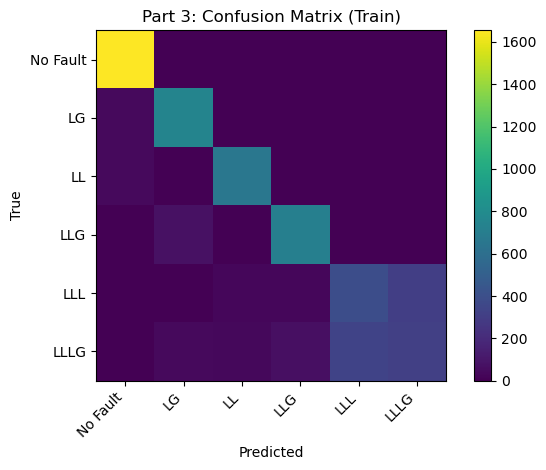


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9441    1.0000    0.9713       710
          LG     0.8645    0.9410    0.9011       339
          LL     0.9153    0.9336    0.9243       301
         LLG     0.8980    0.9059    0.9019       340
         LLL     0.5159    0.4924    0.5039       329
        LLLG     0.4854    0.3912    0.4332       340

    accuracy                         0.8109      2359
   macro avg     0.7705    0.7773    0.7726      2359
weighted avg     0.7965    0.8109    0.8025      2359



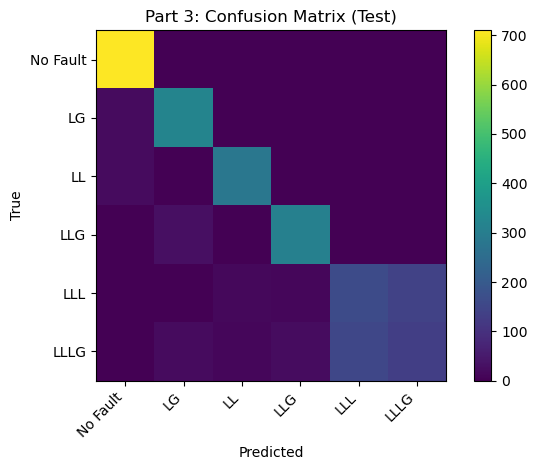

In [19]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- **Q1:** On the test set, the multi-label formulation (Part 2) slightly outperforms regression (Part 1) (e.g., macro f1 ~0.939 vs ~0.930) with more balanced bit-level recall, while the multi-class formulation (Part 3) does well on No Fault, LG, LL, and LLG but has clearly lower f1 for LLL and LLLG (~0.50 and ~0.43). Overall, the **multi-label formulation fits this dataset best**: the task is inherently four binary bits, and modeling each bit with BCE is a natural fit; it also avoids the sharp drop on minority fault types (LLL, LLLG) seen in Part 3.
- **Q2:** Yes. The 4-bit pattern confusion matrices for both Part 1 and Part 2 show **nine** distinct patterns (while only six are valid fault types), and UndefinedMetricWarnings appear for “samples with no predicted labels” / “no true labels.” This indicates that **predicting each bit independently can produce invalid [G,C,B,A] combinations** (e.g., 0100, 1000), because the model does not enforce the physical relationship between ground (G) and phase count, so the four bit outputs can combine into fault patterns that never appear in the training set or are invalid.
- **Q3:** **LLL and LLLG** were the hardest to predict (Part 3 test: LLL f1 ≈ 0.50, LLLG recall ≈ 0.39). One plausible reason is that **three-phase faults (LLL/LLLG) can overlap in feature space with two-phase (LL/LLG) or single-phase (LG) faults**; current/voltage measurements may look similar in some samples. With LLL/LLLG being less dominant in the data, the model underfits the “all three phases faulted” pattern and tends to confuse these with LL or LLG.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [20]:
# Part 5: Binary classifier (Fault vs No Fault)
# Using multi-class style (binary cross-entropy with 1 output) — same structure as Part 2

# 1) Binary labels: 0 = No Fault, 1 = Fault
y_binary = (y_fault >= 1).astype(int)
print('Binary class counts:', dict(zip(['No Fault', 'Fault'], np.bincount(y_binary))))

# 2) 70% / 30% stratified split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary, test_size=0.30, random_state=RANDOM_STATE, stratify=y_binary
)
print('Train size:', X_train_b.shape[0], '| Test size:', X_test_b.shape[0])

# 3) RobustScaler (fit on train only)
scaler_5 = RobustScaler()
X_train_b_s = scaler_5.fit_transform(X_train_b).astype(np.float32)
X_test_b_s = scaler_5.transform(X_test_b).astype(np.float32)

# DataLoaders
Xtr_b = torch.from_numpy(X_train_b_s)
ytr_b = torch.from_numpy(y_train_b.astype(np.float32)).unsqueeze(1)  # (N,1) for BCE
train_loader_5 = DataLoader(TensorDataset(Xtr_b, ytr_b), batch_size=BATCH_SIZE, shuffle=True)

# 4) Binary DNN: 6 -> 16 -> 8 -> 1 logit (BCEWithLogitsLoss)
class DNN_Binary(nn.Module):
    def __init__(self, input_dim=6, h1=16, h2=8, p_drop=0.25):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, 1)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = nn.functional.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)  # logits (N, 1)

model_5 = DNN_Binary().to(device)
loss_fn_5 = nn.BCEWithLogitsLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

# 5) Training
def train_binary(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer_5.zero_grad()
            logits = model(xb)
            loss = loss_fn_5(logits, yb)
            loss.backward()
            optimizer_5.step()
            total += loss.item() * xb.size(0)
        if ep in [1, epochs//2, epochs]:
            print(f'Epoch {ep}/{epochs} | avg loss = {total/len(loader.dataset):.6f}')

train_binary(model_5, train_loader_5)

Binary class counts: {'No Fault': np.int64(2365), 'Fault': np.int64(5496)}
Train size: 5502 | Test size: 2359
Epoch 1/1000 | avg loss = 0.620837
Epoch 500/1000 | avg loss = 0.068523
Epoch 1000/1000 | avg loss = 0.070997


=== Part 5 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9633    0.9994    0.9810      1655
       Fault     0.9997    0.9836    0.9916      3847

    accuracy                         0.9884      5502
   macro avg     0.9815    0.9915    0.9863      5502
weighted avg     0.9888    0.9884    0.9884      5502

Confusion matrix (Train):
 [[1654    1]
 [  63 3784]]


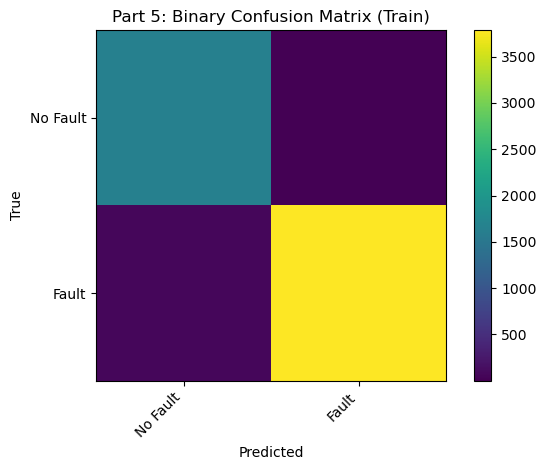


=== Part 5 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9673    0.9986    0.9827       710
       Fault     0.9994    0.9854    0.9924      1649

    accuracy                         0.9894      2359
   macro avg     0.9833    0.9920    0.9875      2359
weighted avg     0.9897    0.9894    0.9894      2359

Confusion matrix (Test):
 [[ 709    1]
 [  24 1625]]


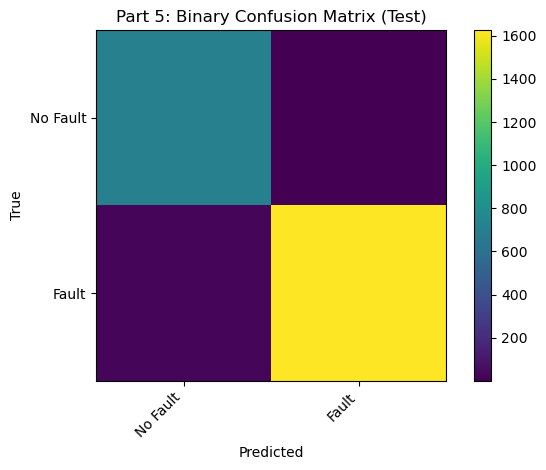

In [21]:
# 6) Evaluation: classification report + confusion matrix (train and test)
@torch.no_grad()
def predict_binary(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy().ravel()
    return (probs >= threshold).astype(int)

pred_train_b = predict_binary(model_5, X_train_b_s)
pred_test_b = predict_binary(model_5, X_test_b_s)

class_names = ['No Fault', 'Fault']
print('=== Part 5 | Train ===')
print(classification_report(y_train_b, pred_train_b, target_names=class_names, digits=4))
cm_train_b = confusion_matrix(y_train_b, pred_train_b, labels=[0, 1])
print('Confusion matrix (Train):\n', cm_train_b)
plot_cm(cm_train_b, 'Part 5: Binary Confusion Matrix (Train)', class_names)

print('\n=== Part 5 | Test ===')
print(classification_report(y_test_b, pred_test_b, target_names=class_names, digits=4))
cm_test_b = confusion_matrix(y_test_b, pred_test_b, labels=[0, 1])
print('Confusion matrix (Test):\n', cm_test_b)
plot_cm(cm_test_b, 'Part 5: Binary Confusion Matrix (Test)', class_names)